In [1]:
import pyspark
import re
import pyspark.sql
from pyspark.sql import *
import pandas as pd
import matplotlib.pyplot as plt
import os.path
from pyspark.sql.functions import *
import json
from pyspark.sql.types import *
import urllib.parse
import builtins

spark = sqlContext = SQLContext(sc)

%matplotlib inline

sc.addPyFile("/home/piccardi/libs/seaborn-0.9.0-py3.5.egg")
import seaborn as sns


### Load data

In [2]:
hover_text = spark.read.parquet("hover_text.parquet")
hover_text

DataFrame[hover: bigint, page_token: string, reference_position: bigint, revision_id: bigint, text: string]

In [3]:
from pyspark.ml.feature import Tokenizer, RegexTokenizer
from pyspark.sql.functions import col, udf
from pyspark.sql.types import IntegerType

contextTokenizer = RegexTokenizer(inputCol="text", outputCol="text_tokens", pattern="\\W")
samples_tokenized = contextTokenizer.transform(hover_text)

samples_tokenized

DataFrame[hover: bigint, page_token: string, reference_position: bigint, revision_id: bigint, text: string, text_tokens: array<string>]

In [4]:
from pyspark.ml.feature import StopWordsRemover

contextRemover = StopWordsRemover(inputCol="text_tokens", outputCol="text_tokens_clean")
samples_clean = contextRemover.transform(samples_tokenized).drop("context_tokens")
samples_clean

DataFrame[hover: bigint, page_token: string, reference_position: bigint, revision_id: bigint, text: string, text_tokens: array<string>, text_tokens_clean: array<string>]

In [5]:
features_compressed = samples_clean.drop("text_tokens").where("SIZE(text_tokens_clean) < 10000")
features_compressed.cache()

DataFrame[hover: bigint, page_token: string, reference_position: bigint, revision_id: bigint, text: string, text_tokens_clean: array<string>]

----------

# Train the model

In [37]:
features_compressed

DataFrame[hover: bigint, page_token: string, reference_position: bigint, revision_id: bigint, text: string, text_tokens_clean: array<string>]

In [38]:
features_compressed.count()

9351579

In [ ]:
# Bad term where the parser failed. They will be replaced with a special token

list_movie = set(["seasonepisodesoriginally","scoressourceratingallmusic",
                 "airedlast", "tban", "tbatbaapril", "overallno", "byoriginal", "ratingsaggregate"])


In [251]:
import re

is_number = re.compile('^\d+$')

def window(iterable, size=2):
    i = iter(iterable)
    win = []
    for e in range(0, size):
        win.append(next(i))
    yield win
    for e in i:
        win = win[1:] + [e]
        yield win

def translate(token):
    if len(token)<=1:
        return ''
    if token in list_movie:
        return '$MovieInfo$'
    if token in list_airline:
        return ''
    if is_number.match(token):
        if len(token) != 4:
            return '$number$'
    return token

def get_words_vectors(row):
    tokens = []
    for t in row.text_tokens_clean:
        token = translate(t)
        if len(token) > 0:
            tokens.append(token)
    text_bigrams = [" ".join(t) for t in window(tokens, size=2) 
                    if '$MovieInfo$' not in t 
                   ]
        
    tokens += text_bigrams
    return Row(hover=row.hover, 
               tokens=tokens,
               reference_position=row.reference_position,
               revision_id=row.revision_id,
               text=row.text
              )

features = spark.createDataFrame(features_compressed.rdd.map(get_words_vectors))
features

DataFrame[hover: bigint, reference_position: bigint, revision_id: bigint, text: string, tokens: array<string>]

-------

In [254]:
from pyspark.ml.feature import CountVectorizer

# fit a CountVectorizerModel from the corpus.
terms_vectorizer = CountVectorizer(inputCol="tokens", 
                                     outputCol="tokens_vector", 
                                     vocabSize=10000)

context_vectorizer_model = terms_vectorizer.fit(features)

result = context_vectorizer_model.transform(features).cache()
result.take(3)

[Row(hover=0, reference_position=19, revision_id=887670753, text='Also, at a genetic level, half-fourth cousins typically do not exhibit greater genetic similarity with one another than with any other individual from the same population.', tokens=['also', 'genetic', 'level', 'half', 'fourth', 'cousins', 'typically', 'exhibit', 'greater', 'genetic', 'similarity', 'one', 'another', 'individual', 'population', 'also genetic', 'genetic level', 'level half', 'half fourth', 'fourth cousins', 'cousins typically', 'typically exhibit', 'exhibit greater', 'greater genetic', 'genetic similarity', 'similarity one', 'one another', 'another individual', 'individual population'], tokens_vector=SparseVector(10000, {17: 1.0, 19: 1.0, 311: 1.0, 425: 1.0, 540: 1.0, 720: 1.0, 1097: 1.0, 1181: 1.0, 1305: 1.0, 2684: 1.0, 4058: 2.0})),
 Row(hover=1, reference_position=27, revision_id=887670753, text='The phenomenon of inbreeding increases the level of homozygotes for autosomal genetic disorders and generally

In [255]:
vocab = context_vectorizer_model.vocabulary

In [256]:
vocab[0:10]

['$number$',
 '$number$ $number$',
 '2018',
 '2017',
 '2019',
 'united',
 '2016',
 'yes',
 '2015',
 'new']

---------

In [257]:
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

-----------
# Train logistic regression

In [260]:
from pyspark.ml.classification import LogisticRegression
mlor = LogisticRegression(labelCol="hover", featuresCol="tokens_vector", regParam=0.001, elasticNetParam=0.0)
mlorModel = mlor.fit(result)
print(mlorModel.summary.areaUnderROC)

0.5793761218012646


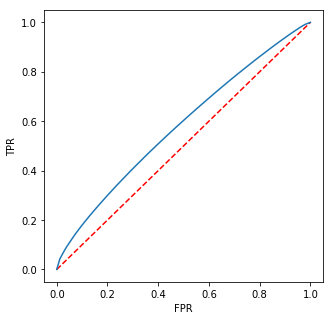

In [261]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(mlorModel.summary.roc.select('FPR').collect(),
         mlorModel.summary.roc.select('TPR').collect())
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In [262]:
values = mlorModel.coefficients.toArray()
coeff={}
for i in range(0, len(vocab)):
    coeff[vocab[i]]=values[i]
    
features_importance = pd.DataFrame.from_dict(coeff, orient="index").reset_index()
features_importance.columns = ["name", "coefficient"]


In [263]:
ctx_unigrams = features_importance[(~features_importance.name.str.contains(" "))]\
    .sort_values("coefficient", ascending=False).head(15)


ctx_bigrams = features_importance[(features_importance.name.str.contains(" "))]\
    .sort_values("coefficient", ascending=False).head(15)

display_side_by_side(ctx_unigrams.set_index("name"), ctx_bigrams.set_index("name"))


,coefficient
name,
multirole,0.561335
$MovieInfo$,0.555397
instagram,0.510477
boyfriend,0.490834
listen,0.467554
connell,0.457427
renewed,0.363443
engaged,0.361933
dating,0.357062


In [264]:
ctx_unigrams = features_importance[(~features_importance.name.str.contains(" "))]\
    .sort_values("coefficient", ascending=True).head(15)


ctx_bigrams = features_importance[(features_importance.name.str.contains(" "))]\
    .sort_values("coefficient", ascending=True).head(15)

display_side_by_side(ctx_unigrams.set_index("name"), ctx_bigrams.set_index("name"))


,coefficient
name,
bywritten,-0.468206
boryspil,-0.348801
energia,-0.346985
mixtape,-0.346800
eswatini,-0.306014
duggar,-0.303022
bvmi,-0.295571
rashtriya,-0.293326
starred,-0.265236


----------